In [1]:
import csv
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from verstack.stratified_continuous_split import scsplit # pip install verstack
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import scipy
import sklearn

from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

import gensim
import os
import collections
import smart_open
import random
from math import floor, ceil
from gensim.test.utils import get_tmpfile
from sklearn import preprocessing

In [2]:
# Load the training data
train_data = pd.read_csv("train.csv")
train_data

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


### Define some functions that we will use in our project

In [3]:
## to check if there were missing values in the data set
def check_missing_value(df):
    numbers_rows = df.shape[0]
    numbers_columns = df.shape[1]
    print(f'data rows : {numbers_rows} | columns : {numbers_columns}')
    print('The percentage of empty values')
    print(df.isna().sum()/len(df))
    # df.isna().sum()
    
## to check if there were any duplicated entries in the data set
def check_duplicated(df):
    mask_duplicated = df.duplicated(keep=False)
    print(df[mask_duplicated])
    
## to process the timestamp
def timestamp_process(df):
    df['time_date'] = pd.to_datetime(df['timestamp'], unit='ms')
    # df.time_date.head(5)
    df['day'] = df.time_date.dt.day.astype(np.int8)
    df['month'] = df.time_date.dt.month.astype(np.int8)
    df['hour'] = df.time_date.dt.hour.astype(np.int8)
    df['day_of_week'] = df.time_date.dt.dayofweek.astype("int8") #Monday=0, Sunday=6 
    # df.describe()

def one_hot_coding_week(df):
    # list of columns to encode using One-Hot-Encoding
    columns_to_encode = ["day_of_week"]
    # encode those columns
    encoded_data = pd.get_dummies(df[columns_to_encode], columns=columns_to_encode)
    encoded_data
    encoded_data.rename({'day_of_week_0': 'Monday', 
                     'day_of_week_1': "Tuesday", 
                     'day_of_week_2': "Wednesday",
                     'day_of_week_3': "Thursday",
                     'day_of_week_4': "Friday",
                     'day_of_week_5': "Saturday",
                    'day_of_week_6': "Sunday"},axis='columns', inplace=True)
    # add encoded columns to the data
    df = pd.concat([df, encoded_data], axis=1)   
    return df

def catagorized_hour(df):
    df['day_hour']=0
    df['day_hour'].loc[(df['hour']>5)&(df['hour']<22)] = 1
    df['night_hour']=0
    df['night_hour'].loc[(df['hour']<=5 )|(df['hour']>=22)] = 1

def catagorized_length(df):
    df['short']=0
    df['short'].loc[df['text'].str.len()<45] = 1
    df['medium']=0
    df['medium'].loc[(df['text'].str.len()>=45)&(df['text'].str.len()<=80)] = 1
    df['long']=0
    df['long'].loc[df['text'].str.len()>80] = 1

# Features to indicate whether a tweet has a url, hashtag, mention 
def has_hashtag_mention_urls(df):

    df['has_url'] = 0
    df.loc[df['urls'] != '[]', 'has_url'] = 1

    df['has_mention'] = 0
    df.loc[df['mentions'] != '[]', 'has_mention'] = 1

    df['has_hashtag'] = 0
    df.loc[df['hashtags'] != '[]', 'has_hashtag'] = 1

def Follower_friend(df):
    ###Followers/#Friends No. of followers and friends ratio Log transformed and then standardized
    ## Ref: CIKM AnalytiCup 2020: COVID-19 Retweet Prediction with Personalized Attention
    df['Follower_friend']=df['followers_count']/df['friends_count']
    df['Follower_friend']=df['Follower_friend'].replace(np.inf,0)
    df['Follower_friend']=df['Follower_friend'].replace(np.nan, 0)
    df['Follower_friend']=(df['Follower_friend']-df['Follower_friend'].mean())/df['Follower_friend'].std()

# def length(df):
#     df['length']=0
#     df['length'].loc[df['text'].str.len()<45] = 1
    
#     df['length'].loc[(df['text'].str.len()>=45)&(df['text'].str.len()<=80)] = 2
    
#     df['length'].loc[df['text'].str.len()>80] = 3


### A toturial in Kaggle: https://www.kaggle.com/code/houssemayed/lstm-models-for-regression-on-text-data/notebook
def read_corpus(fname, tokens_only=False):
    with smart_open.smart_open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            if tokens_only:
                yield gensim.utils.simple_preprocess(line)
            else:
                # For training data, add tags
                if i==0:
                    pass
                else:
                    yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line)[1:], 
                                                                                 gensim.utils.simple_preprocess(line)[0]) # tag is first item, the rest is text
                                                           
##A tutorial in stackoverflow:https://stackoverflow.com/questions/56681210/convert-a-column-in-a-dask-dataframe-to-a-taggeddocument-for-doc2vec
def tag_corp(corp,tag):
    return gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(corp), ([tag]))



### processing the data set with the functions that we defined previously

In [4]:

timestamp_process(train_data)
train_data=one_hot_coding_week(train_data)
catagorized_hour(train_data)
catagorized_length(train_data)
has_hashtag_mention_urls(train_data)
Follower_friend(train_data)
# length(train_data)

In [5]:
train_data.head(5)

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,...,Sunday,day_hour,night_hour,short,medium,long,has_url,has_mention,has_hashtag,Follower_friend
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],...,0,0,1,1,0,0,0,0,0,-0.021331
1,populaire,0,0,86,1016,284,[],[],0,[],...,0,1,0,1,0,0,0,0,0,-0.021456
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],...,0,1,0,1,0,0,0,0,0,-0.021339
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],...,0,1,0,0,0,1,1,0,0,-0.021510
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],...,0,1,0,1,0,0,0,0,0,-0.021284


In [6]:
check_duplicated(train_data)
### so there isn't any duplicated data
check_missing_value(train_data)
## So there isn't any missing values

Empty DataFrame
Columns: [text, retweets_count, favorites_count, followers_count, statuses_count, friends_count, mentions, urls, verified, hashtags, timestamp, TweetID, time_date, day, month, hour, day_of_week, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday, day_hour, night_hour, short, medium, long, has_url, has_mention, has_hashtag, Follower_friend]
Index: []

[0 rows x 33 columns]
data rows : 353969 | columns : 33
The percentage of empty values
text               0.0
retweets_count     0.0
favorites_count    0.0
followers_count    0.0
statuses_count     0.0
friends_count      0.0
mentions           0.0
urls               0.0
verified           0.0
hashtags           0.0
timestamp          0.0
TweetID            0.0
time_date          0.0
day                0.0
month              0.0
hour               0.0
day_of_week        0.0
Monday             0.0
Tuesday            0.0
Wednesday          0.0
Thursday           0.0
Friday             0.0
Saturday           0.0
Sun

## Feature selection

Text(0, 0.5, 'Retweet number')

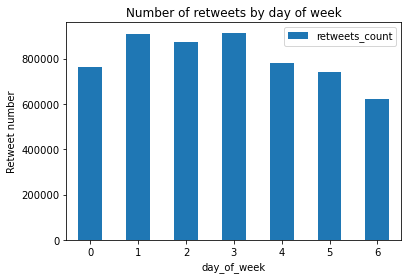

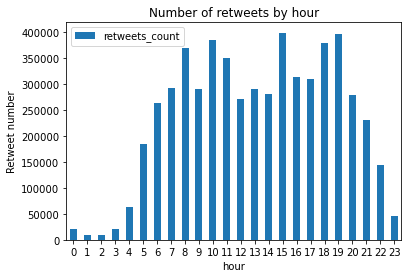

In [7]:
## we want to study the relation between time and number of retweet 
no_of_retweets_week = train_data.groupby('day_of_week', as_index=False)['retweets_count'].sum()
no_of_retweets_hour = train_data.groupby('hour', as_index=False)['retweets_count'].sum()
no_of_retweets_month = train_data.groupby('month', as_index=False)['retweets_count'].sum()
no_of_retweets_day = train_data.groupby('day', as_index=False)['retweets_count'].sum()

# no_of_retweets_week
# no_of_retweets_hour

ax1 = no_of_retweets_week.plot.bar(x='day_of_week', y='retweets_count', rot=0)
ax1.set_title('Number of retweets by day of week')
plt.ylabel("Retweet number")

ax2 =no_of_retweets_hour.plot.bar(x='hour', y='retweets_count', rot=0)
ax2.set_title('Number of retweets by hour')
plt.ylabel("Retweet number")

## The number of retweets varies in each day of the week , and in different hour
## More retweets from 6 AM to 21 PM, Less retweets from 22 PM to 5 AM
## So we are going to creat catagorized features : Monday to Sunday, day hour and night hour

Text(0, 0.5, 'Cumulative distribution probability')

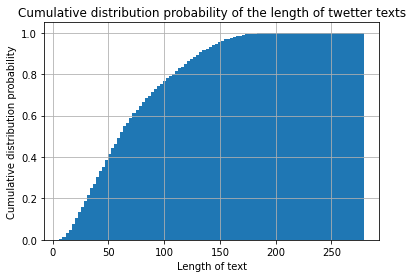

In [8]:
ax3=train_data['text'].str.len().hist(cumulative=True, density=1, bins=100)
ax3.set_title('Cumulative distribution probability of the length of twetter texts')
plt.xlabel("Length of text")
plt.ylabel("Cumulative distribution probability")
## from the cumulative distribution probability of the length of twetter text, 
## 1/3 of their length is (0,45)
## 1/3 of their length is (45,80)
## 1/3 of their length is (80,250+)
## we can catagorized the texts as three catagories :"short","medium","long" [ref: RETWEET PREDICTIVE MODEL IN TWITTER:  Chapiter 5]

In [9]:
n_short = train_data['short'].sum()
n_medium =  train_data['medium'].sum()
n_long =  train_data['long'].sum()
print("the number of short text is: ",n_short,"\n", 
      "the number of medium text is: ",n_medium,"\n", 
      "the number of long text is: ",n_long,"\n")

### The number of retweets are evenly distributed in three catogories

the number of short text is:  117754 
 the number of medium text is:  113738 
 the number of long text is:  122477 



In [10]:
features_corr = [
#    'text',
    'retweets_count',
    'favorites_count',
    'followers_count',
    'statuses_count',
    'friends_count',
    #'mentions',
    #'urls',
    'verified',
    #'hashtags',
#     'timestamp',
#     'TweetID',
#     'time_date',
#     'day',
#     'month',
#     'hour',
#     'day_of_week',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday',
    'day_hour',
    'night_hour',
    'short',
    'medium',
    'long',
    'has_url',
#     'has_mention',
    'has_hashtag',
    'Follower_friend',
]

target = "retweets_count"

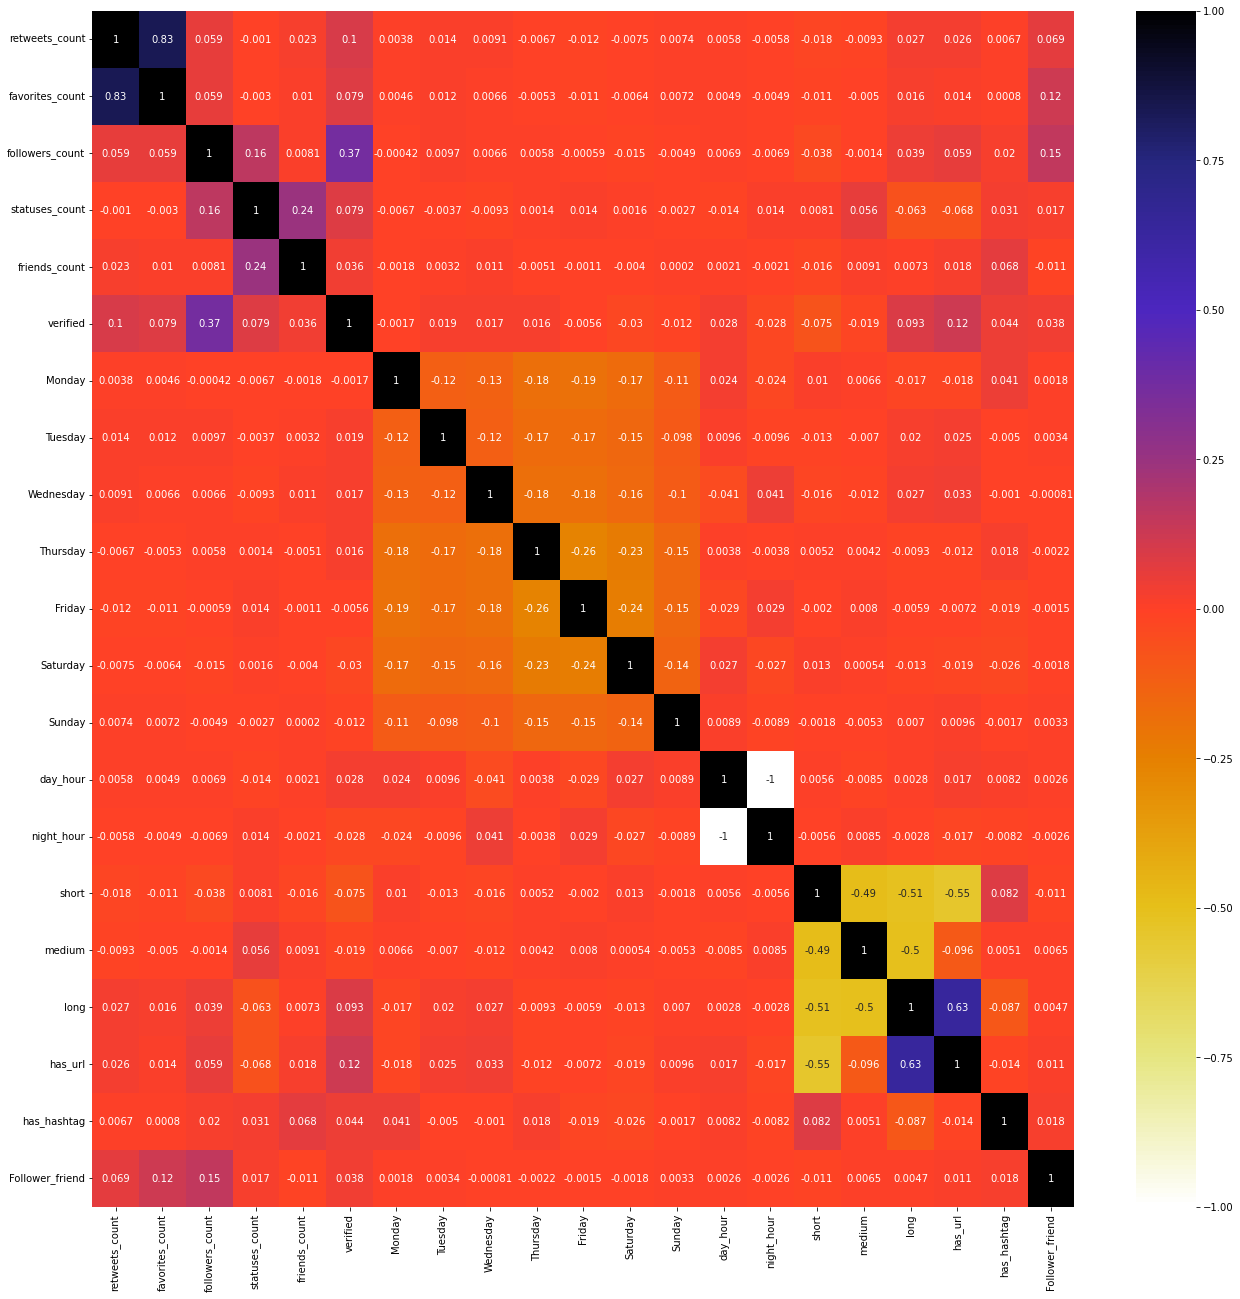

In [11]:
## Plot the correlation between features using correlation matrice
cor = train_data[features_corr].corr()
plt.figure(figsize=(22,22))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()

[0.17906804 0.18521843 0.16323274 0.18403769 0.00767861 0.01059635
 0.00924945 0.00851902 0.01250829 0.01292833 0.01027502 0.00784574
 0.00762244 0.00766544 0.00395701 0.00446378 0.00530886 0.01082512
 0.01276055 0.15623909]


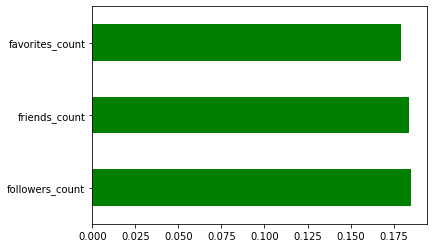

In [12]:
## evaluate feature importance
X = train_data[features_corr]
X = X.drop('retweets_count', axis=1)
y = train_data['retweets_count'] 
X=X.iloc[0:5000]
y=y.iloc[0:5000]
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(3).plot(kind='barh',color='green')
plt.show()

#### Judging from the correlation matrics and feature importance, we selected the following features：'text',  'favorites_count', 'followers_count', 'friends_count', 'verified', 'long'

In [13]:

f_select = [
   'text',
#    'retweets_count',
    'favorites_count',
    'followers_count',
    'friends_count',
    'verified',
    'long'
]

target = "retweets_count"

## Training Model

In [14]:
## Slpit dataset


X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)
X_train.head(5)

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,...,Sunday,day_hour,night_hour,short,medium,long,has_url,has_mention,has_hashtag,Follower_friend
134757,fière insoumise fière jean luc melenchon avril...,15,88,3723,128299,4843,[],['https://t.co/qwn6ggwtgs'],0,[],...,0,1,0,0,0,1,1,0,0,-0.021375
111796,macron arrêter condamner prison justice pareil...,0,0,0,423,39,[],[],0,[],...,0,1,0,0,1,0,0,0,0,-0.021510
314,éric zemmour message femmes écoute message fem...,2,0,2276,99602,2136,[],"['https://t.co/9tzkl28bxo', 'https://t.co/zhdv...",0,[],...,0,1,0,0,0,1,1,0,0,-0.021323
116119,travail jamais renoncer défendre démocratie,0,0,76,332,309,[],[],0,[],...,0,1,0,1,0,0,0,0,0,-0.021466
185379,moment garde gauche serre main flagrant,0,0,503,8971,1772,[],[],0,[],...,0,1,0,1,0,0,0,0,0,-0.021460


In [15]:

X_train = X_train[f_select]
X_test = X_test[f_select]


X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)


In [130]:
X_train

,text,favorites_count,followers_count,friends_count,verified,long
0,saviez déjà big oil mauvais famille rockefelle...,0,77,151,0,1
1,collage amiens,20,793,136,0,0
2,silence total merdias officiels botte macron c...,5,1829,1459,0,1
3,rt dernière abruti penser refuse débat,0,1316,1275,0,0
4,waaah macron remise centimes vient monter trip...,0,3,0,0,1
...,...,...,...,...,...,...
247773,oui chrétiens gauche,0,67,97,0,0
247774,technocrate bureaucrate idéologue éric zemmour...,17,8921,787,0,1
247775,gros twist partie raciste zemmour constitué ra...,0,109,168,0,0
247776,mal genou gauche suite traumatisme,0,8135,5460,0,0


In [16]:
y_train_final=y_train.reset_index(drop=True)
y_test_final=y_test.reset_index(drop=True)

### Word embbeding process

In [23]:
tagged_document = [tag_corp(x,y) for x,y in list(zip(train_data['text'],train_data['retweets_count']))]
train_corpus = [tag_corp(x,y) for x,y in list(zip(X_train['text'],y_train))]
test_corpus = [tag_corp(x,y) for x,y in list(zip(X_test['text'],y_test))]

In [27]:


model = gensim.models.doc2vec.Doc2Vec(tagged_document, vector_size=5, window=2, min_count=1, workers=4)

In [28]:
fname = get_tmpfile("my_doc2vec_model")

model.save(fname)
model = gensim.models.doc2vec.Doc2Vec.load(fname)

In [31]:
# model.build_vocab(train_corpus) 

In [30]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs) # 20 mins?

CPU times: total: 1min 26s
Wall time: 1min 5s


In [32]:
train_targets, train_regressors = zip(*[(doc.words, doc.tags[0]) for doc in train_corpus])
test_targets, test_regressors = zip(*[(doc.words, doc.tags[0]) for doc in test_corpus])

In [33]:
X = []
for i in range(len(train_targets)):
    X.append(model.infer_vector(train_targets[i]))
train_x = np.asarray(X)
train_x.shape

(247778, 5)

In [34]:
Y = np.asarray(train_regressors)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
train_y = le.transform(Y)
np.mean(train_y)

11.222267513661423

In [35]:
test_list = []
for i in range(len(test_targets)):
    test_list.append(model.infer_vector(test_targets[i]))
test_x = np.asarray(test_list)

In [36]:
test_x

array([[-0.05931527, -0.10116872, -0.18100813, -0.00806033, -0.06990368],
       [ 0.01558958, -0.28606808, -0.1560704 , -0.4371721 ,  0.04010632],
       [-0.12858048, -0.12456408, -0.41990432, -0.52242345, -0.11776668],
       ...,
       [-0.24307403, -0.12214078,  0.03185515, -0.16242287, -0.22679782],
       [-0.06643429, -0.14264514, -0.03656562, -0.1827537 , -0.10284788],
       [-0.25850075, -0.38253218, -0.37566262, -0.57109666, -0.1437144 ]],
      dtype=float32)

In [37]:
test_x = pd.DataFrame(test_x)
train_x= pd.DataFrame(train_x)

In [38]:
test_x

,0,1,2,3,4
0,-0.059315,-0.101169,-0.181008,-0.008060,-0.069904
1,0.015590,-0.286068,-0.156070,-0.437172,0.040106
2,-0.128580,-0.124564,-0.419904,-0.522423,-0.117767
3,-0.126702,-0.038430,-0.137378,-0.252158,-0.134262
4,-0.039263,0.011846,0.027868,-0.146319,-0.103181
...,...,...,...,...,...
106186,-0.089412,0.063447,-0.202087,-0.132015,-0.158261
106187,-0.587622,-0.305038,-0.513097,-0.626966,-0.503057
106188,-0.243074,-0.122141,0.031855,-0.162423,-0.226798
106189,-0.066434,-0.142645,-0.036566,-0.182754,-0.102848


In [39]:
## We want to combien the word features with other features
X_train_final = pd.concat([X_train.drop(['text'],axis=1),train_x],axis=1)
X_test_final = pd.concat([X_test.drop(['text'],axis=1),test_x],axis=1)

## USE X_train_final,y_train_final, X_test_final, y_test_final for trainning

## Trainning

## Gradiant boosting

In [44]:
# Now we can train our model. Here we chose a Gradient Boosting Regressor and we set our loss function 
reg = GradientBoostingRegressor()#reg = RandomForestRegressor() #
#reg = LinearRegression()
# We fit our model using the training data
reg.fit(X_train_final, y_train_final)
# And then we predict the values for our testing set
y_pred = reg.predict(X_test_final)
# We want to make sure that all predictions are non-negative integers
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]

print("Prediction error:", mean_absolute_error(y_true=y_test_final, y_pred=y_pred))


Prediction error: 7.184488327636052


## linear regression

In [46]:
lin_reg = sklearn.linear_model.LinearRegression()
lin_reg = lin_reg.fit(X_train_final, y_train_final)
y_pred_lin_reg = lin_reg.predict(X_test_final)
y_pred_lin_reg = [int(value) if value >= 0 else 0 for value in y_pred_lin_reg]
print("Prediction error for linear regression:", mean_absolute_error(y_true=y_test_final, y_pred=y_pred_lin_reg))

Prediction error for linear regression: 10.710728781158478


## Regression trees

In [47]:
model_tree = sklearn.tree.DecisionTreeRegressor(max_depth=8, random_state=0)
model_tree = model_tree.fit(X_train_final, y_train_final)
y_pred_tree = model_tree.predict(X_test_final)
y_pred_tree = [int(value) if value >= 0 else 0 for value in y_pred_tree]
print("Prediction error for regression tree:", mean_absolute_error(y_true=y_test_final, y_pred=y_pred_tree))

Prediction error for regression tree: 7.70236649056888


### hyperparameter tuning

In [50]:
def plot_max_depth_influence(max_depth_ls, X_val, y_val, X_test, y_test):
    """Fit a Decision Tree with different maximum depths
    and plot learning curve for train and test sets.
    """

    mae_train = []
    mae_test = []

    # loop over different maximum depths
    # and compute MAE
    for max_depth in max_depth_ls:
        print(f"Fitting with max_depth = {max_depth}")
        model_tree = sklearn.tree.DecisionTreeRegressor(max_depth=max_depth)
        model_tree = model_tree.fit(X_val, y_val)
        y_pred_val = model_tree.predict(X_val)
        y_pred_test = model_tree.predict(X_test)
        mae_train.append(mean_absolute_error(y_val, y_pred_val))
        mae_test.append(mean_absolute_error(y_test, y_pred_test))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

    # Plot learning curves
    axes.plot(max_depth_ls, mae_train, color='red', label='Train')
    axes.plot(max_depth_ls, mae_test, color='blue', label='Test')
    axes.set_title('MAE regarding max_depth')
    axes.legend()
    plt.xlabel("max_depth")
    plt.ylabel("MAE")
    plt.grid()
    fig.show()

Fitting with max_depth = 2
Fitting with max_depth = 4
Fitting with max_depth = 8
Fitting with max_depth = 10
Fitting with max_depth = 16
Fitting with max_depth = 32


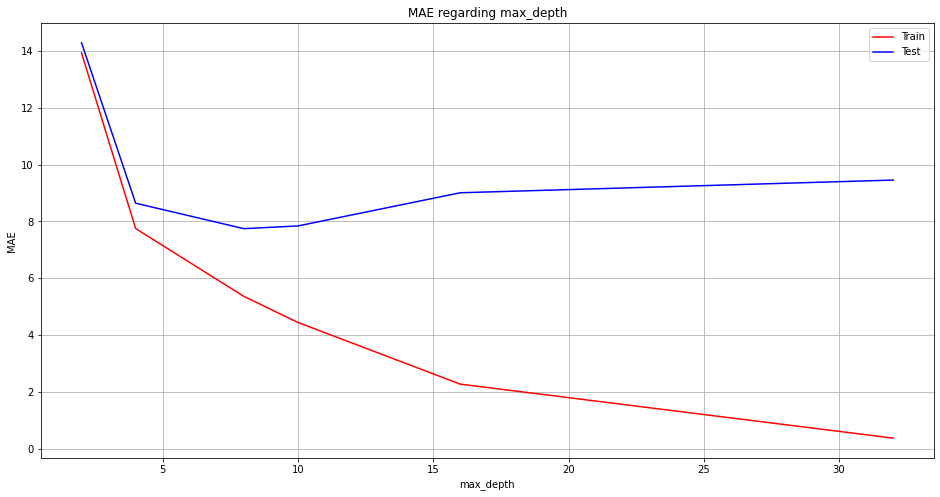

In [51]:
max_depth_ls = [2, 4, 8, 10,16, 32]
plot_max_depth_influence(
    max_depth_ls,
    X_train_final, y_train_final,
    X_test_final, y_test_final,
)


## We found that for max_depth >8 ,Trainning MAE decreasing while Testing MAE increasing, which might be an overfitting
## so we need want to use max_depth = 8

## Ramdom forests

In [61]:
model_rf = sklearn.ensemble.RandomForestRegressor(
    n_estimators=5,
    max_depth=16,
    random_state=0,
    n_jobs=-1
)
model_rf.fit(X_train_final, y_train_final)
y_pred_rf = model_rf.predict(X_test_final)
y_pred_rf = [int(value) if value >= 0 else 0 for value in y_pred_rf]
print("Prediction error for random forest:", mean_absolute_error(y_true=y_test_final, y_pred=y_pred_rf))

Prediction error for random forest: 7.828827301748736


In [56]:
def plot_estimators_influence(estimators, X_val, y_val, X_test, y_test):
    """Fit a Decision Tree with different maximum depths
    and plot learning curve for train and test sets.
    """

    mae_train = []
    mae_test = []

    # loop over different maximum depths
    # and compute MAE
    for nestimators in estimators:
        print(f"Fitting with n_estimators = {nestimators}")
        model_tree = sklearn.ensemble.RandomForestRegressor(n_estimators=nestimators)
        model_tree = model_tree.fit(X_val, y_val)
        y_pred_val = model_tree.predict(X_val)
        y_pred_test = model_tree.predict(X_test)
        mae_train.append(mean_absolute_error(y_val, y_pred_val))
        mae_test.append(mean_absolute_error(y_test, y_pred_test))

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

    # Plot learning curves
    axes.plot(estimators, mae_train, color='red', label='Train')
    axes.plot(estimators, mae_test, color='blue', label='Test')
    axes.set_title('MAE regarding max_depth')
    axes.legend()
    plt.xlabel("n_estimators")
    plt.ylabel("MAE")
    plt.grid()
    fig.show()

Fitting with max_depth = 2
Fitting with max_depth = 5
Fitting with max_depth = 10
Fitting with max_depth = 50


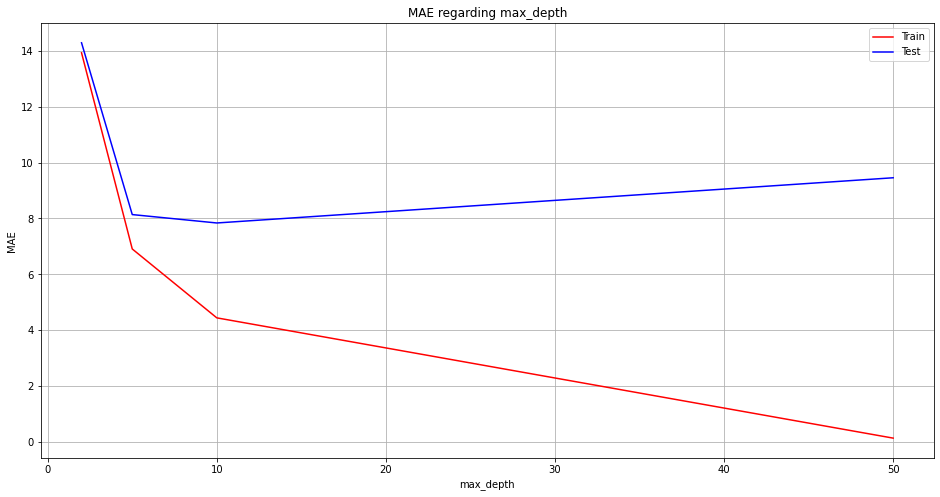

In [60]:
estimators = [2,5,10,50,]
plot_max_depth_influence(
    estimators,
    X_train_final, y_train_final,
    X_test_final, y_test_final,
)
## We will choose n_estimator = 5 

## nn

In [ ]:
f_select_nn = [
#    'text',
#    'retweets_count',
    'favorites_count',
    'followers_count',
    'friends_count',
    'verified',
    'long'
]

target = "retweets_count"

X_train, X_test, y_train, y_test = scsplit(train_data, train_data['retweets_count'], stratify=train_data['retweets_count'], train_size=0.7, test_size=0.3)

X_train = X_train[f_select_nn]
X_test = X_test[f_select_nn]


X_train.shape

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

x = np.asarray(X_train).astype('float32')
y = np.asarray(y_train).astype('float32')


model = Sequential()
model.compile(optimizer='adam', loss='mae')
model.add(Dense(4, input_shape=(5,), activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='relu'))


model.fit(x, y, epochs=150, batch_size=10)

In [ ]:
x_test = np.asarray(X_test).astype('float32')

y_pred = model.predict(x_test)
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]

print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

In [ ]:
lin_reg = sklearn.linear_model.LinearRegression()
reg = GradientBoostingRegressor()
reg_LGBM = LGBMRegressor()
reg_XGB = XGBRegressor()
reg_CatBoost = CatBoostRegressor()

In [ ]:
estimators=[
            ('linear', lin_reg),
            ('gradient',reg), 
            ('LGBM', reg_LGBM),
            ('XGB', reg_XGB),
            ('CatBoost', reg_CatBoost),
                ]

vrg = VotingRegressor(estimators)
vrg.fit(X_train, y_train)

In [ ]:
y_pred = vrg.predict(X_test)
y_pred = [int(value) if value >= 0 else 0 for value in y_pred]

print("Prediction error:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

## Evaluation

In [63]:
eval_data = pd.read_csv("evaluation.csv")

timestamp_process(eval_data)
eval_data=one_hot_coding_week(eval_data)
catagorized_hour(eval_data)
catagorized_length(eval_data)
has_hashtag_mention_urls(eval_data)
Follower_friend(eval_data)
# check_missing_value(train_data)



In [64]:
X_pred = eval_data[f_select]

In [65]:
X_pred

,text,favorites_count,followers_count,friends_count,verified,long
0,descendue pourcentage vote,0,85,327,0,0
1,photo demande arbre généalogique,0,427,443,0,0
2,dossiers promis poste gars vraiment fiable,6,1127,1596,0,0
3,lol cas faut second tour macron sortir définit...,2,1699,2036,0,1
4,zemmour putain discours propagandiste littéral...,0,249,369,0,1
...,...,...,...,...,...,...
117985,balais inexcusable vote veut,0,4,64,0,0
117986,balayant rap borloo mâles blcs commis faute fo...,0,744,894,0,1
117987,triste réalité covid tue malades macron veille...,12,924,159,0,0
117988,excellente idée pouvez réussir démarche crise ...,0,5,80,0,1


In [69]:
test_targets=list(X_pred['text'])

In [77]:
test_list = []
for i in range(len(X_pred['text'])):
    test_list.append(model.infer_vector(X_pred['text'][i].split()))
test_x = np.asarray(test_list)

In [79]:
test_x = pd.DataFrame(test_x)

In [80]:
X_pred_final = pd.concat([X_pred.drop(['text'],axis=1),test_x],axis=1)


## At last we choose gradiant boosting because it has least MAE

In [82]:

# Predict the number of retweets for the evaluation dataset
y_pred = reg.predict(X_pred_final)
y_pred = [int(value
    ) if value >= 0 else 0 for value in y_pred]
# Dump the results into a file that follows the required Kaggle template
with open("gbr_predictions.txt", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "retweets_count"])
    for index, prediction in enumerate(y_pred):
        writer.writerow([str(eval_data['TweetID'].iloc[index]) , str(int(prediction))])
